In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from sklearn.metrics import classification_report
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
import functools



In [2]:
ROOT = "D:/Mariam Ashraf/ultrasound-nerve-segmentation/"
trainpath = "D:/Mariam Ashraf/ultrasound-nerve-segmentation/train/"
testpath = "D:/Mariam Ashraf/ultrasound-nerve-segmentation/test/"

masks = [os.path.join(trainpath,i) for i in os.listdir(trainpath) if "mask" in i]
imgs = [i.replace("_mask","") for i in masks]
imgs_test = [os.path.join(testpath,i) for i in os.listdir(testpath)]

df = pd.DataFrame({"image":imgs,"mask":masks})
df_train, df_val = train_test_split(df,test_size = 0.15)
df_test =  pd.DataFrame({"image":imgs_test})
# df_test


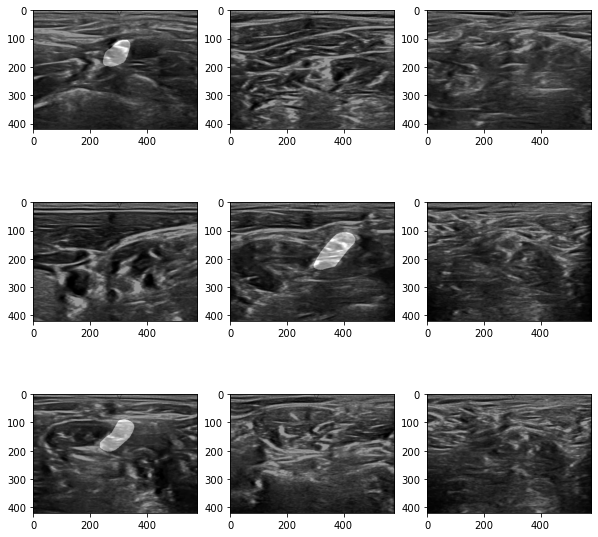

In [37]:
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    ii = random.randint(0, len(df))
    fig.add_subplot(rows,cols,i)
    img_path=df['image'][ii]
    msk_path=df['mask'][ii]
    plt.imshow(np.array(Image.open(img_path)), cmap = 'gray')
    plt.imshow(np.array(Image.open(msk_path)),alpha=0.4, cmap = 'gray')
plt.show()

In [3]:
train_data = [np.array(Image.open(df_train.iloc[i,0])) for i in range(len(df_train))]
train_data_masks = [np.array(Image.open(df_train.iloc[i,1])) for i in range(len(df_train))]
val_data = [np.array(Image.open(df_val.iloc[i,0])) for i in range(len(df_val))]
val_data_masks = [np.array(Image.open(df_val.iloc[i,1])) for i in range(len(df_val))]
test_data = [np.array(Image.open(df_test.iloc[i,0])) for i in range(len(df_test))]
# train_data

In [4]:
labels_train=[]
labels_val=[]
for i in range(len(train_data_masks)):
    if np.count_nonzero(train_data_masks[i]):
        labels_train.append(0)
    else:
        labels_train.append(1)
for i in range(len(df_val)):
    if np.count_nonzero(val_data_masks[i]):
        labels_val.append(0)
    else:
        labels_val.append(1)
#print(df_train.iloc[0][1])
# print(labels_train.count(1))
# print(labels_val.count(1))

In [5]:
def process_res(img, label):
  img=np.array(img)[:,:,:,np.newaxis]
  img_3channels=img.repeat(3,axis=-1)
  
  if label is not None:
    label = tf.convert_to_tensor(label)
    label = tf.one_hot(label, depth=2)

  data = tf.image.resize(tf.convert_to_tensor(img_3channels), [224,224])
  return data, label


train_ds = process_res(train_data,labels_train)
# print(train_ds[0].shape)
val_ds = process_res(val_data,labels_val)
test_ds = process_res(test_data,None)
# print(train_ds[1])


### Transfer learning using ResNet50 on imagnet for classification

In [6]:
base_model = ResNet50(weights='imagenet')

x = base_model.output
x = Dense(1024, activation='relu')(x)

output= Dense(2, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)


In [36]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [7]:
for layer in model.layers[:155]:
   layer.trainable = False
for layer in model.layers[155:]:
   layer.trainable = True

In [8]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5, patience=2, verbose=1)

e_stop = tf.keras.callbacks.EarlyStopping( monitor="loss", patience=5, 
          verbose=0,  restore_best_weights=True)

callbacks = [reduce_lr, e_stop]
# print(val_ds[1].shape)

In [9]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
# model.summary()

history = model.fit(x=train_ds[0],y=train_ds[1],
           validation_data = val_ds,
           batch_size=64,
           shuffle =True,
           callbacks = callbacks,
           epochs=25)

Epoch 1/25
75/75 [==============================] - 18s 180ms/step - loss: 0.6138 - accuracy: 0.6573 - val_loss: 0.7005 - val_accuracy: 0.5638 - lr: 0.0010
Epoch 2/25
75/75 [==============================] - 12s 160ms/step - loss: 0.5122 - accuracy: 0.7572 - val_loss: 0.9000 - val_accuracy: 0.6206 - lr: 0.0010
Epoch 3/25
75/75 [==============================] - 12s 160ms/step - loss: 0.4675 - accuracy: 0.7826 - val_loss: 0.6075 - val_accuracy: 0.7541 - lr: 0.0010
Epoch 4/25
75/75 [==============================] - 12s 161ms/step - loss: 0.4208 - accuracy: 0.8098 - val_loss: 0.6191 - val_accuracy: 0.6277 - lr: 0.0010
Epoch 5/25
75/75 [==============================] - 12s 161ms/step - loss: 0.3901 - accuracy: 0.8344 - val_loss: 0.4860 - val_accuracy: 0.7837 - lr: 0.0010
Epoch 6/25
75/75 [==============================] - 12s 157ms/step - loss: 0.3401 - accuracy: 0.8576 - val_loss: 0.6382 - val_accuracy: 0.7388 - lr: 0.0010
Epoch 7/25
75/75 [==============================] - ETA: 0s - lo

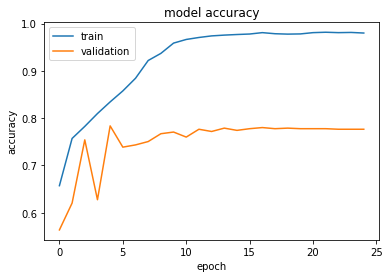

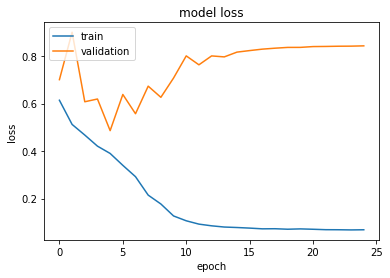

In [34]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [35]:
results = model.evaluate(val_ds[0], val_ds[1], batch_size=64)
predictions = model.predict(val_ds[0], batch_size=64, verbose=1)
pred_bool = tf.one_hot(np.argmax(predictions, axis=1),depth=2)
test_pred = model.predict(test_ds[0], batch_size=64, verbose=1)
# print(test_pred)
print(classification_report(val_ds[1], pred_bool))
# print(pred_bool)
# print(results)
# print(predictions.shape)
# predictions

87/87 [==============================] - 9s 107ms/step
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       359
           1       0.79      0.83      0.81       487

   micro avg       0.78      0.78      0.78       846
   macro avg       0.77      0.77      0.77       846
weighted avg       0.78      0.78      0.78       846
 samples avg       0.78      0.78      0.78       846



### Transfer learning from VGG in Unet model for segmentation

In [11]:
from tensorflow.keras.layers import BatchNormalization,Conv2DTranspose,Conv2D,concatenate
from tensorflow.keras.applications.vgg16 import VGG16

In [12]:
def Unet_model(input_shape):
    # input: input_shape (height, width, channels) 
    # return model
    input_shape = input_shape
    base_VGG = VGG16(include_top = False, 
                   weights = "imagenet", 
                   input_shape = input_shape)

    # freezing all layers in VGG16 
    for layer in base_VGG.layers: 
        layer.trainable = False

    # the bridge (exclude the last maxpooling layer in VGG16) 
    bridge = base_VGG.get_layer("block5_conv3").output
    print(bridge.shape)

    # Decoder now
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    up1 = BatchNormalization()(up1)
    print(up1.shape)
    concat_1 = concatenate([up1, base_VGG.get_layer("block4_conv3").output], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat_1)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up2 = BatchNormalization()(up2)
    print(up2.shape)
    concat_2 = concatenate([up2, base_VGG.get_layer("block3_conv3").output], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat_2)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)


    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up3 = BatchNormalization()(up3)
    print(up3.shape)
    concat_3 = concatenate([up3, base_VGG.get_layer("block2_conv2").output], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat_3)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up4 = BatchNormalization()(up4)
    print(up4.shape)
    concat_4 = concatenate([up4, base_VGG.get_layer("block1_conv2").output], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat_4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    conv10 = BatchNormalization()(conv10)
    print(conv10.shape)

    model_ = Model(inputs=[base_VGG.input], outputs=[conv10])

    return model_


In [13]:
U_model = Unet_model((224,224,3)) 

(None, 14, 14, 512)
(None, 28, 28, 512)
(None, 56, 56, 256)
(None, 112, 112, 128)
(None, 224, 224, 64)
(None, 224, 224, 1)


In [14]:
def process_mask(mask):
  mask=np.array(mask)[:,:,:,np.newaxis]
  masks = tf.image.resize(tf.convert_to_tensor(mask), [224,224])
  return masks

train_masks = process_mask(train_data_masks)
val_masks = process_mask(val_data_masks)
# plt.imshow(train_masks[564],cmap='gray')
# plt.show()
# print(train_masks[5][100])
# print(val_masks.shape)
# print(len(train_data_masks))

In [15]:
#Get images with with nerve only (positive classification)
positive_train=(np.where(np.array(labels_train)==1)[0]).tolist()
positive_val=(np.where(np.array(labels_val)==1)[0]).tolist()
test_max=np.argmax(test_pred,axis=1)
positive_test=(np.where(np.array(test_max)==1)[0]).tolist()

In [33]:
print(len(positive_train))

2825


In [16]:
train_data_positive=[]
train_masks_positive=[]
val_data_positive=[]
val_masks_positive=[]

for train_idx in positive_train:
    train_data_positive.append(train_ds[0][train_idx])
    train_masks_positive.append(train_masks[train_idx])

for mask_idx in positive_val:
    val_data_positive.append(val_ds[0][mask_idx])
    val_masks_positive.append(val_masks[mask_idx])


In [17]:
data = tf.convert_to_tensor(train_data_positive)
mask = tf.convert_to_tensor(train_masks_positive)
val = tf.convert_to_tensor(val_data_positive)
vmask = tf.convert_to_tensor(val_masks_positive)

In [18]:
# U_model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss, 
#                     metrics=[iou, dice_coef, 'binary_accuracy'])
U_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

u_history = U_model.fit(x=data,y=mask,
           validation_data = (val,vmask),
           batch_size=10,
           callbacks = callbacks,
           shuffle = True,
           epochs=10,
           verbose=1)

Epoch 1/10
283/283 [==============================] - 72s 243ms/step - loss: 0.3764 - accuracy: 0.8952 - val_loss: 0.3168 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 2/10
283/283 [==============================] - 64s 226ms/step - loss: 0.0039 - accuracy: 0.9999 - val_loss: 0.0486 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
283/283 [==============================] - 64s 227ms/step - loss: 3.0176e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/10
283/283 [==============================] - 64s 227ms/step - loss: 7.1538e-05 - accuracy: 1.0000 - val_loss: 7.0756e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 5/10
283/283 [==============================] - 64s 227ms/step - loss: 4.7245e-05 - accuracy: 1.0000 - val_loss: 3.1231e-05 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
283/283 [==============================] - ETA: 0s - loss: 1.8342e-05 - accuracy: 1.0000
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
283/283 [=====

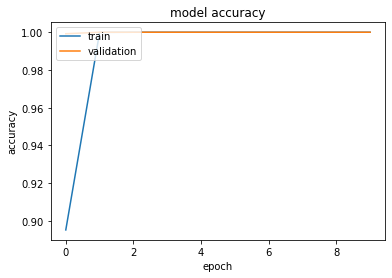

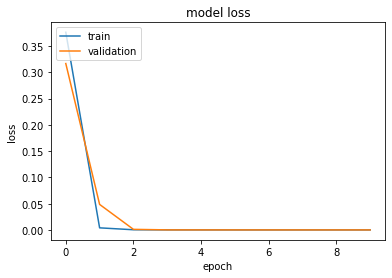

In [19]:
# summarize history for accuracy
plt.plot(u_history.history['accuracy'])
plt.plot(u_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(u_history.history['loss'])
plt.plot(u_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()